In [17]:
import numpy as np
import time, os, sys
from glob import glob
from tifffile import imread
from tqdm import tqdm

# from urllib.parse import urlparse
# import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# mpl.rcParams['figure.dpi'] = 96
%config InlineBackend.figure_format = 'retina'

from cellpose import utils, models, transforms, dynamics, plot

import mxnet as mx
from mxnet import init, nd

%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
def plot_nd(arr, nd=3, figsize=(15,15)):
    fig, axes = plt.subplots(ncols=nd, figsize=figsize)
    for img, ax in zip(arr, axes.flatten()):
        ax.imshow(img, cmap='gray')
    plt.show()

## Load dsb dataset

In [3]:
HOME = '/home/lis-paul'
# PATH = "data/dsb2018/dsb2018_sub1/"
PATH = "data/centuri/train/"
# path = os.path.join(HOME, "data/dsb2018/dsb2018_sub1/images/*.tif")
pathX = os.path.join(HOME, PATH+"images/*.tif")
pathY = os.path.join(HOME, PATH+"masks/*.tif")
X_file = sorted(glob(pathX))
Y_file = sorted(glob(pathY))
print(len(X_file), len(Y_file))

X = list(map(imread,X_file))
Y = list(map(imread,Y_file))
# n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]


5 5


In [4]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

## manual assign train/val index for debugging
ind_train = [1,2,3,4]
ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   5
- training:         4
- validation:       1


## load default models

In [5]:
# _ = mx.ndarray.array([1, 2, 3], ctx=mx.gpu(0))

In [6]:
model0 = models.Cellpose(gpu=True, net_avg=False, batch_size=8, model_type='nuclei')
type(model0)

>>>> using GPU


cellpose.models.Cellpose

In [7]:
model0.cp.device, model0.cp.batch_size, model0.cp.diam_mean

(gpu(0), 8, 15.0)

In [8]:
model0.cp.pretrained_model, model0.pretrained_size

('/home/lis-paul/.cellpose/models/nuclei_0',
 '/home/lis-paul/.cellpose/models/size_nuclei_0.npy')

In [9]:
train_data, test_data, run_test = transforms.reshape_data(X_trn, X_val, channels=[0,0])

In [10]:
X_val[0].shape, test_data[0].shape

((1022, 1022), (2, 1022, 1022))

## precalculate flow from labels

In [29]:
%%time
flow_trn = dynamics.labels_to_flows(Y_trn)
flow_val = dynamics.labels_to_flows(Y_val)

  0%|          | 0/4 [00:00<?, ?it/s]

NOTE: computing flows for labels (could be done before to save time)


  0%|          | 0/1 [00:00<?, ?it/s]

NOTE: computing flows for labels (could be done before to save time)


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

CPU times: user 6.02 s, sys: 12.6 ms, total: 6.03 s
Wall time: 6.02 s


In [11]:
%%time
flow_trn2 = dynamics.labels_to_flows2(Y_trn)
flow_val2 = dynamics.labels_to_flows2(Y_val)

  0%|          | 0/4 [00:00<?, ?it/s]

NOTE: computing flows for labels (could be done before to save time)


  0%|          | 0/1 [00:00<?, ?it/s]

NOTE: computing flows for labels (could be done before to save time)


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

CPU times: user 1.01 s, sys: 16.2 ms, total: 1.02 s
Wall time: 1.02 s


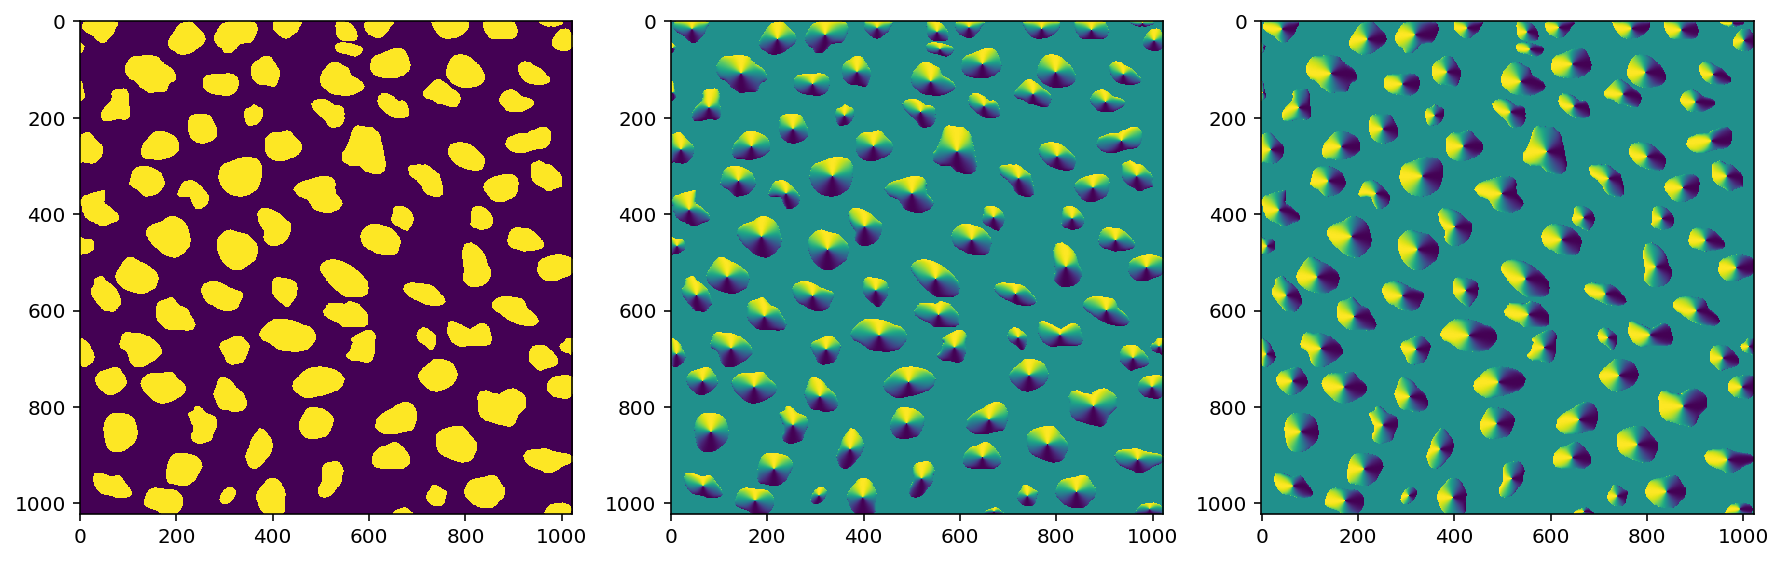

In [31]:
plot_nd(flow_trn[0])

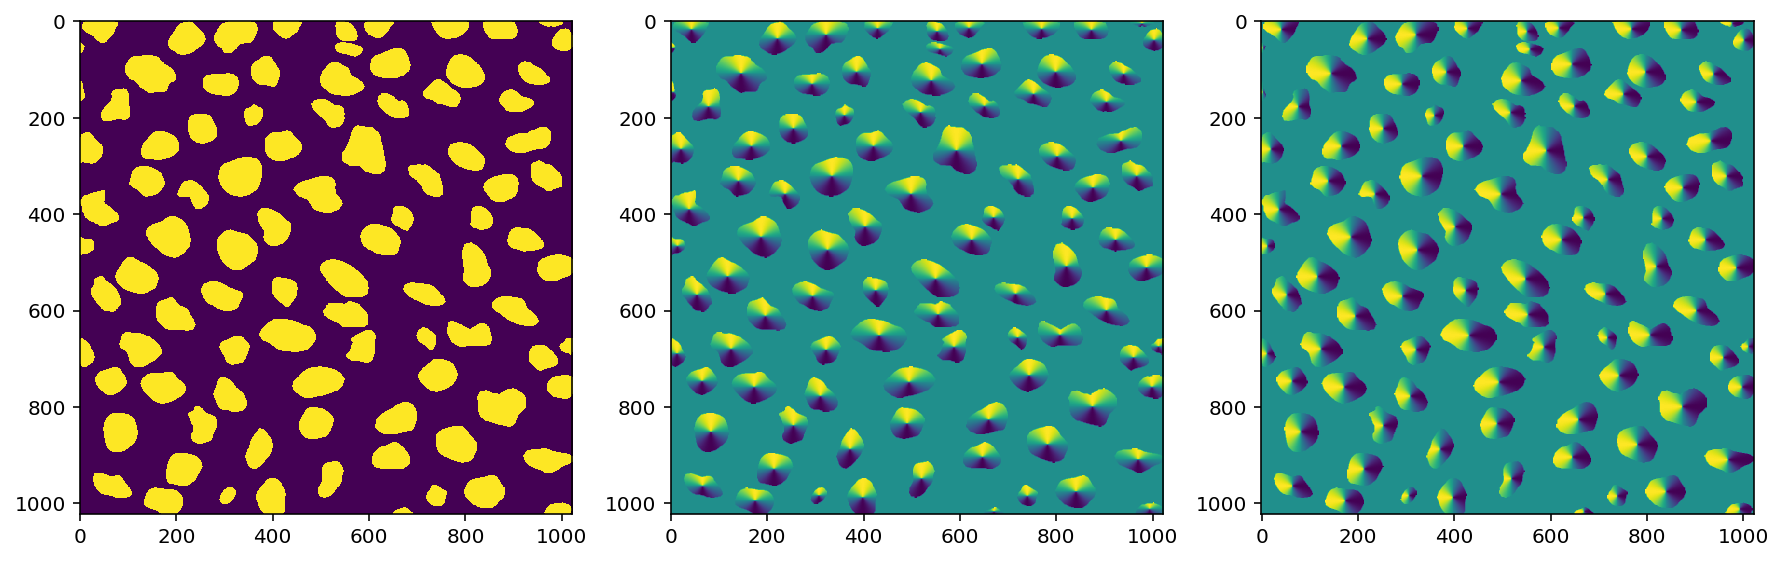

In [32]:
plot_nd(flow_trn2[0])

## compare the model weights from freshly initialized, pretrained, and trained models

### make a sample input for model initialization 

In [19]:
train_data, test_data, run_test = transforms.reshape_data(X_trn[:4], test_data=X_val, channels=[0,0])

In [55]:
# %%debug
imgi, lbl, _ = transforms.random_rotate_and_resize(train_data, Y=flow_trn2[:4],
                                        rescale=[3.54839557, 3.58205398, 3.71150964, 3.79136636], scale_range=0.5)

In [24]:
print(imgi[0].shape)
 ## A context (ctx) describes the device type and ID on which computation should be carried on.
X    = nd.array(imgi)

(2, 224, 224)


### visualize transformed/augmented img/labels 

In [38]:
lbl[0].shape, imgi[0].shape

((3, 224, 224), (2, 224, 224))

In [49]:
arrs = [np.concatenate([i[[0]], l]) for l, i in zip(lbl, imgi)]
len(arrs), arrs[0].shape

(4, (4, 224, 224))

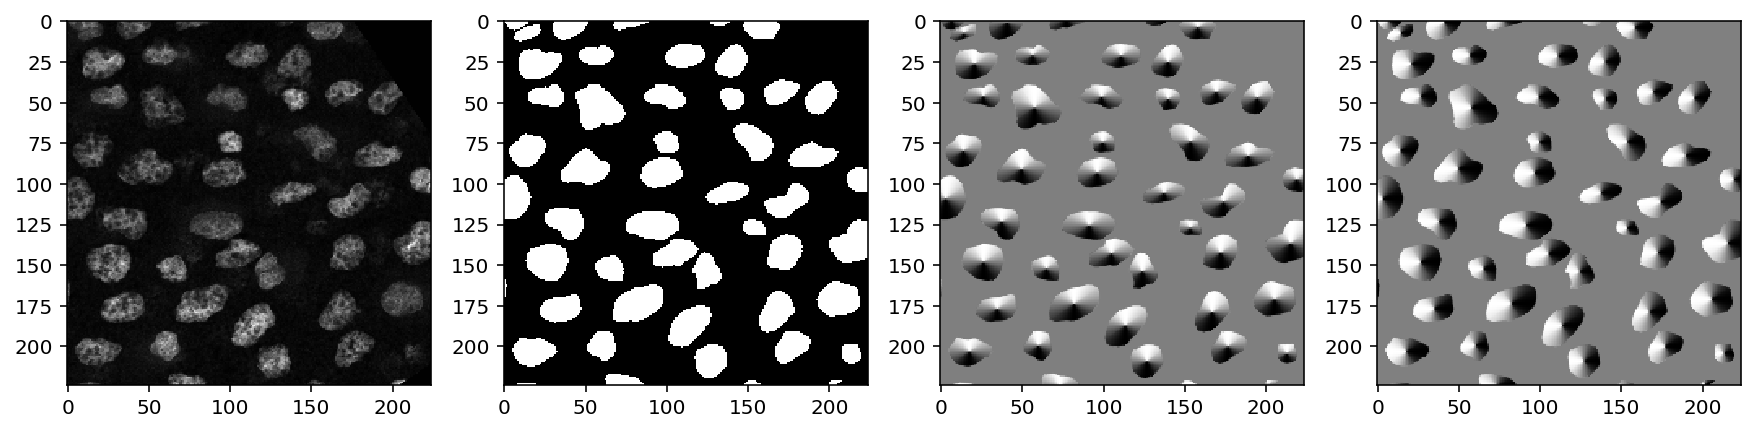

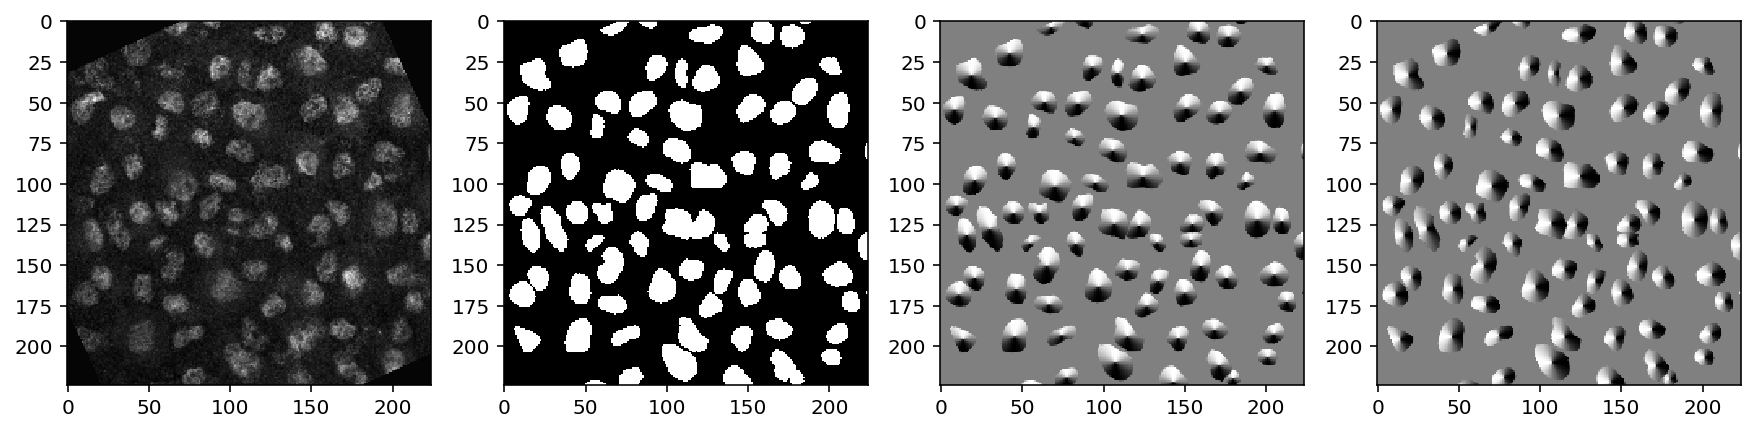

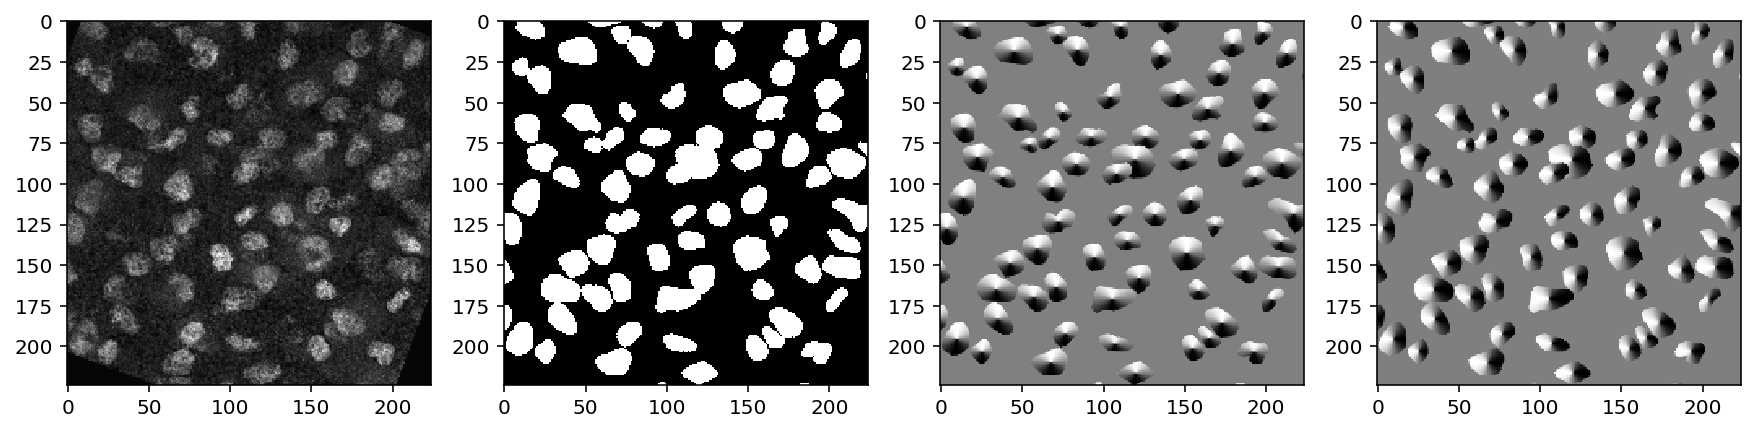

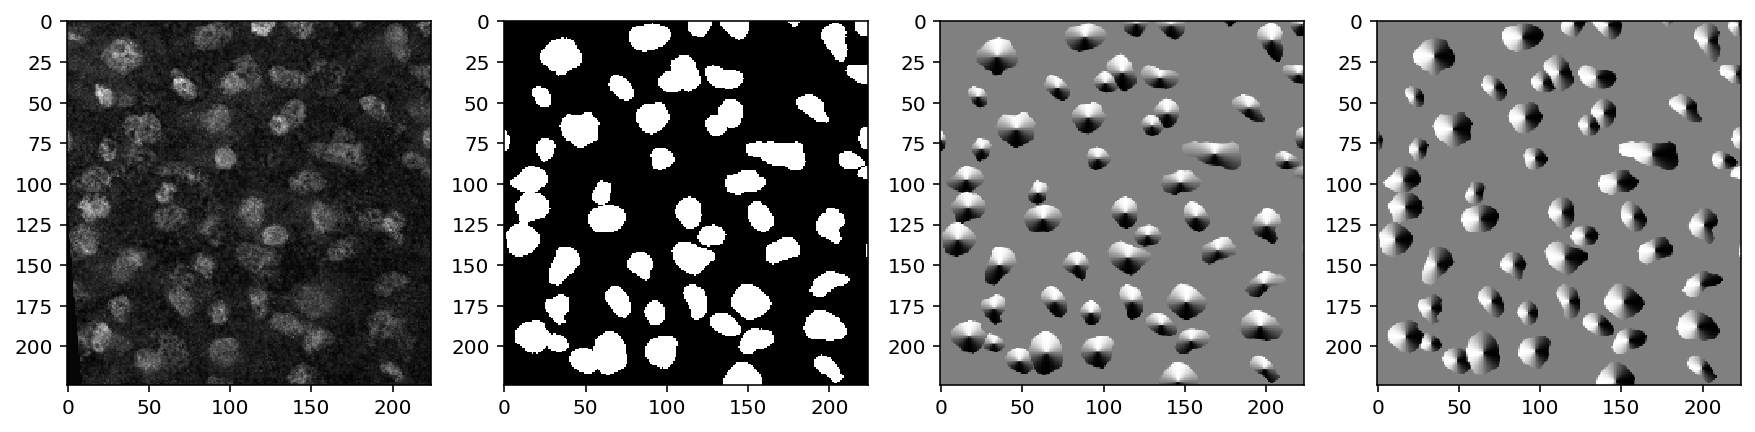

In [53]:
for l in arrs:
    plot_nd(l, nd=4)

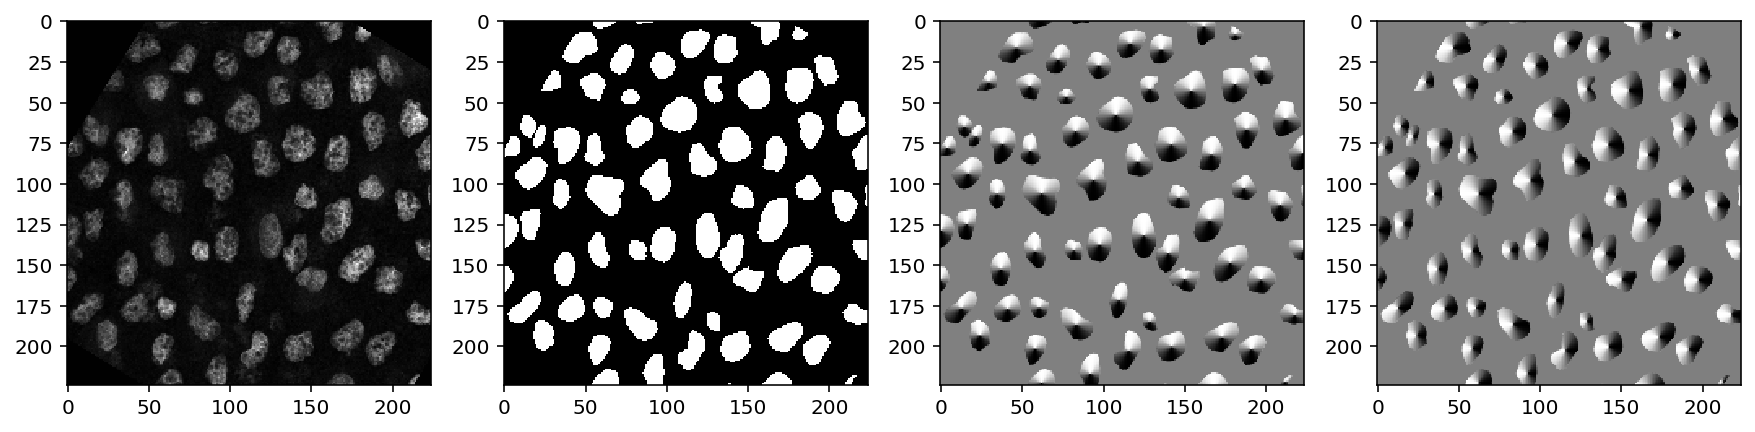

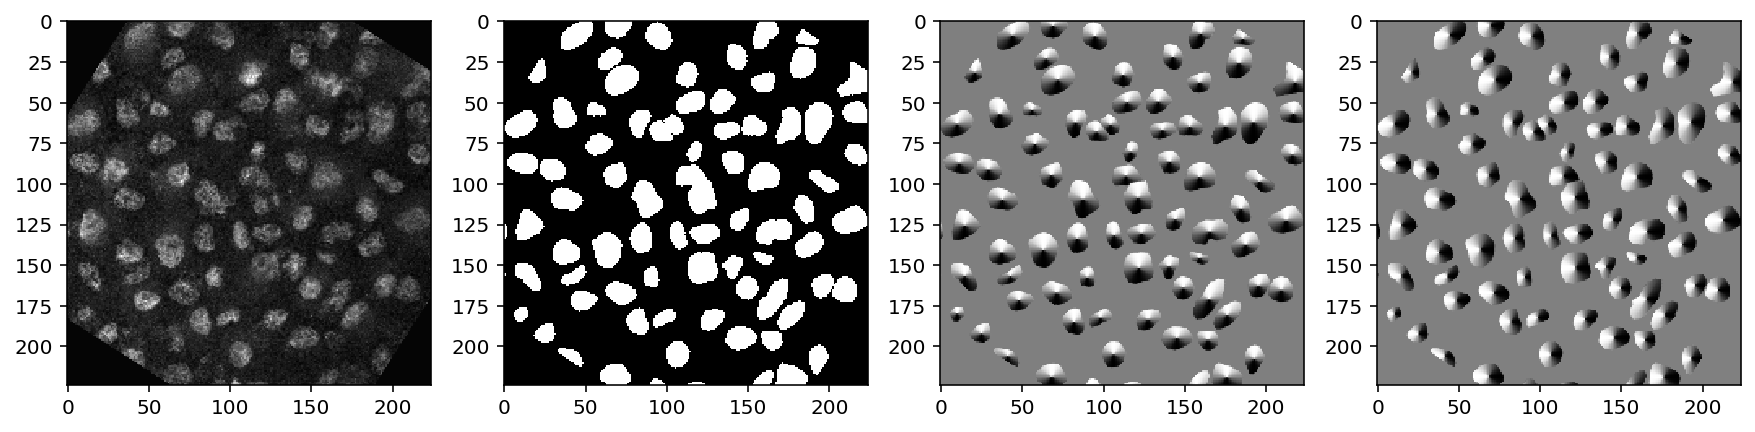

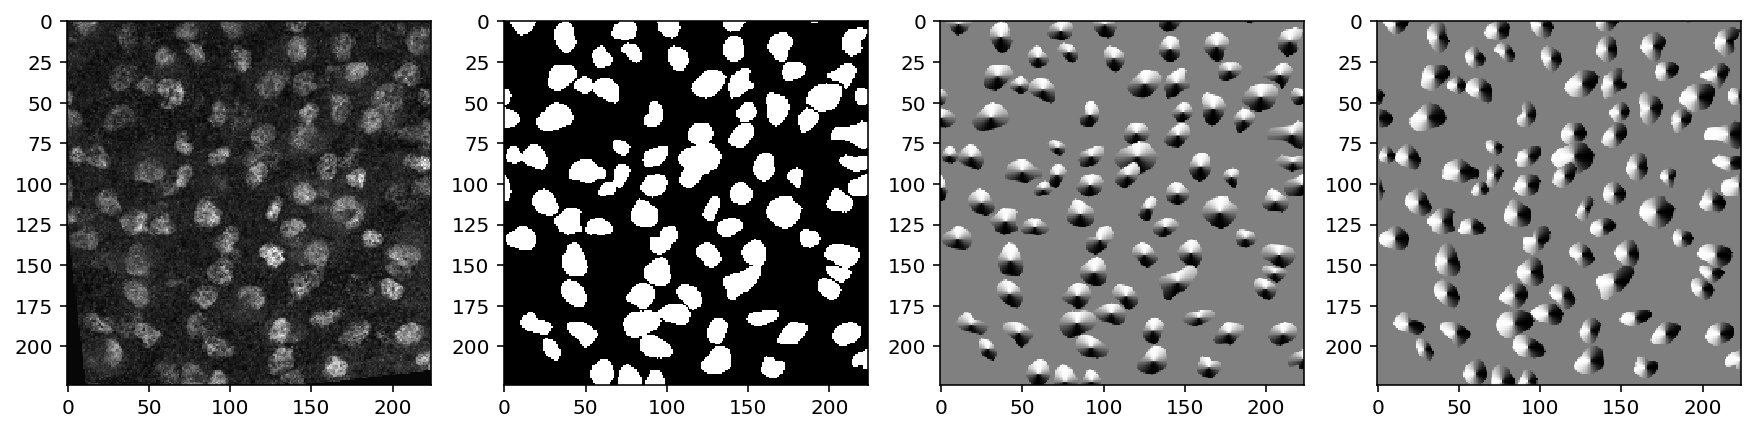

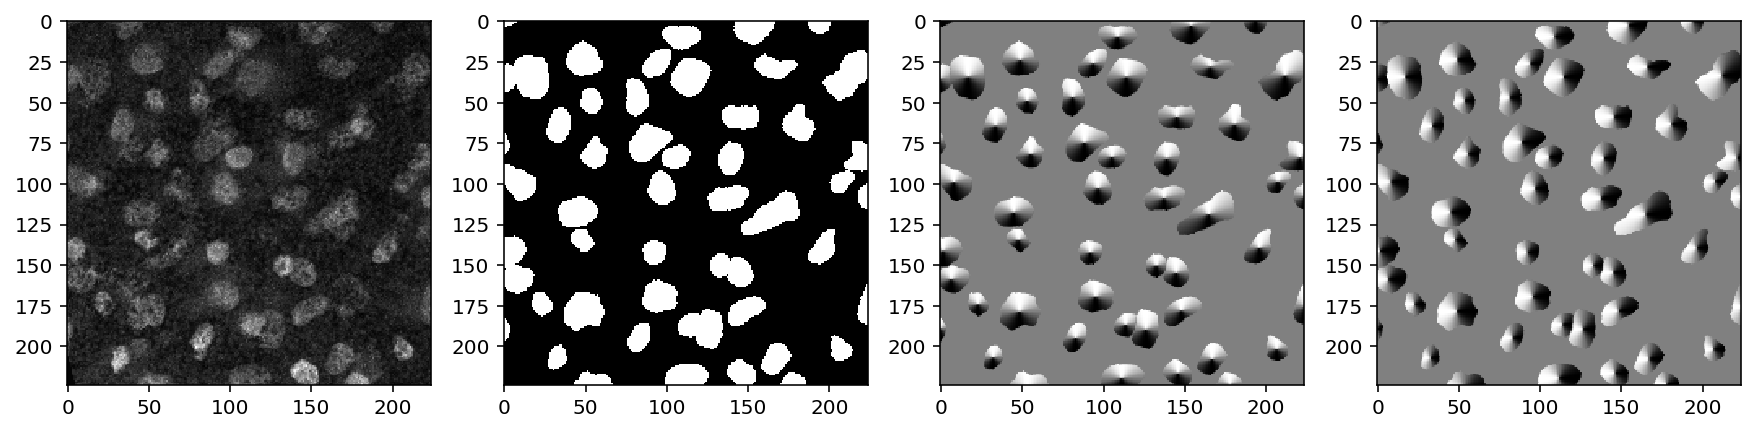

In [56]:
arrs = [np.concatenate([i[[0]], l]) for l, i in zip(lbl, imgi)]
for l in arrs:
    plot_nd(l, nd=4)

### Freshly initialized model without pretrained parameters

In [16]:
cpnet = models.CellposeModel(gpu=True, diam_mean=15.0, batch_size=8, pretrained_model=False, device=model0.cp.device, net_avg=False, unet=False)


In [17]:
# cpnet.net.initialize(init=init.Xavier(), force_reinit=True)
cpnet.net.initialize(force_reinit=True)
y, style = cpnet.net(X)

In [18]:
cpnet.net.downsample.down[0].conv[0][2].weight.data()[0]


[[[-0.00613896 -0.03968295  0.00958075]
  [-0.05106945 -0.06736943 -0.02462026]
  [ 0.01646897 -0.04904552  0.0156934 ]]

 [[-0.03887501  0.01637076 -0.01589154]
  [ 0.06212472  0.05636378  0.02545484]
  [-0.007007   -0.0196689   0.01582889]]]
<NDArray 2x3x3 @cpu(0)>

### pretrained model parameters

In [19]:
model0.cp.net.downsample.down[0].conv[0][2].weight.data()[0]


[[[ 0.04114713  0.0824549   0.5053643 ]
  [-0.10932951 -0.87627375 -0.20008686]
  [ 0.20691864 -0.23023081  0.08594982]]

 [[-0.01360054  0.00572765 -0.00556034]
  [ 0.02173528  0.0197194   0.00890682]
  [-0.00245167 -0.0068812   0.00553805]]]
<NDArray 2x3x3 @gpu(0)>

Parameter after trained for 500 epochs

In [22]:
model0.cp.net.downsample.down[0].conv[0][2].weight.data()[0]


[[[-0.03321636  0.01613303  0.40410134]
  [-0.15363842 -0.9065523  -0.26584458]
  [ 0.13819715 -0.28483343  0.01356527]]

 [[-0.01349027  0.00568122 -0.00551528]
  [ 0.02155902  0.01955957  0.0088346 ]
  [-0.0024318  -0.00682541  0.00549316]]]
<NDArray 2x3x3 @gpu(0)>

## Train with default parameters

### test the diameter function for precalculated flowdef diameters(masks):


In [111]:
""" get median 'diameter' of masks """
masks = flow_trn[0]
masks.shape

(1022, 1022)

In [112]:
l, counts = np.unique(np.int32(masks), return_counts=True)
l,counts

(array([0, 1], dtype=int32), array([743575, 300909]))

In [108]:
counts = counts[1:]
md = np.median(counts**0.5)
md, counts**0.5

(1116.0456708597944, array([1682.00862067,  550.08272105]))

In [110]:
diam_train = np.array([utils.diameters(flow_trn[k][0])[0] for k in range(len(flow_trn))])
diam_train

array([548.55172956, 486.43499052, 546.19685096, 562.96092227])

### try training

In [33]:
model0.cp.device

gpu(0)

In [35]:
model0.cp.train(X_trn, Y_trn, test_data=X_val, test_labels=Y_val, channels=[0,0], train_flows=flow_trn, test_flows=flow_val,
              pretrained_model=None, save_path='../', save_every=100, 
              learning_rate=0.2, n_epochs=500, weight_decay=0.00001, batch_size=4, rescale=True)

>>>> training network with 2 channel input <<<<
>>>> saving every 100 epochs
>>>> median diameter = 15
>>>> LR: 0.20000, batch_size: 4, weight_decay: 0.00001
>>>> ntrain = 4
>>>> ntest = 1
(2, 1022, 1022)
Epoch 0, Time  1.3s, Loss 0.7124, Loss Test 0.4187, LR 0.0000
Epoch 1, Time  1.5s, Loss 0.6655, Loss Test 0.4189, LR 0.0222
saving network parameters to: ../models/cellpose_False__2020_05_25_17_39_37.432746
Epoch 2, Time  1.7s, Loss 0.7371, Loss Test 0.4169, LR 0.0444
Epoch 3, Time  1.8s, Loss 0.7231, Loss Test 0.4123, LR 0.0667
Epoch 4, Time  2.0s, Loss 0.6709, Loss Test 0.4105, LR 0.0889
Epoch 5, Time  2.1s, Loss 0.5969, Loss Test 0.4171, LR 0.1111
Epoch 6, Time  2.3s, Loss 0.5445, Loss Test 0.4267, LR 0.1333
Epoch 7, Time  2.4s, Loss 0.4742, Loss Test 0.4289, LR 0.1556
Epoch 8, Time  2.6s, Loss 0.5236, Loss Test 0.4239, LR 0.1778
Epoch 9, Time  2.7s, Loss 0.5155, Loss Test 0.4092, LR 0.2000
Epoch 10, Time  2.9s, Loss 0.4787, Loss Test 0.3989, LR 0.2000
Epoch 20, Time  4.1s, Loss 0.

### load trained model parameters

In [36]:
# path = '../models/cellpose_False__2020_05_25_17_04_11.191577'
path = '../models/cellpose_False__2020_05_25_17_39_37.432746'
cpnet2 = models.CellposeModel(gpu=True, diam_mean=15.0, batch_size=8, pretrained_model=path, device=model0.cp.device, net_avg=False, unet=False)


In [34]:
model0.cp.net.downsample.down[0].conv[0][2].weight.data()[0]


[[[ 0.04114713  0.0824549   0.5053643 ]
  [-0.10932951 -0.87627375 -0.20008686]
  [ 0.20691864 -0.23023081  0.08594982]]

 [[-0.01360054  0.00572765 -0.00556034]
  [ 0.02173528  0.0197194   0.00890682]
  [-0.00245167 -0.0068812   0.00553805]]]
<NDArray 2x3x3 @gpu(0)>

In [37]:
cpnet2.net.downsample.down[0].conv[0][2].weight.data()[0]


[[[-0.04261043 -0.01184517  0.39662385]
  [-0.16004884 -0.90654963 -0.27657637]
  [ 0.13281374 -0.287448    0.01202662]]

 [[-0.01349027  0.00568122 -0.00551528]
  [ 0.02155902  0.01955957  0.0088346 ]
  [-0.0024318  -0.00682541  0.00549316]]]
<NDArray 2x3x3 @gpu(0)>

In [25]:
cpnet2.net.downsample.down[0].conv[0][2].weight.data()[0]


[[[-0.03321636  0.01613303  0.40410134]
  [-0.15363842 -0.9065523  -0.26584458]
  [ 0.13819715 -0.28483343  0.01356527]]

 [[-0.01349027  0.00568122 -0.00551528]
  [ 0.02155902  0.01955957  0.0088346 ]
  [-0.0024318  -0.00682541  0.00549316]]]
<NDArray 2x3x3 @gpu(0)>

### visualize prediction with trained model

In [19]:
## nuclei diam = 60, rescale = 15/60 = 0.25
masks, flows, styles = model0.cp.eval(X_val, channels=[0,0], invert=False, rescale=0.25, do_3D=False, net_avg=False, 
                                  tile=True, flow_threshold=0.4, cellprob_threshold=0.0, compute_masks=True, progress=None)

In [20]:
masks[0].shape

(1022, 1022)

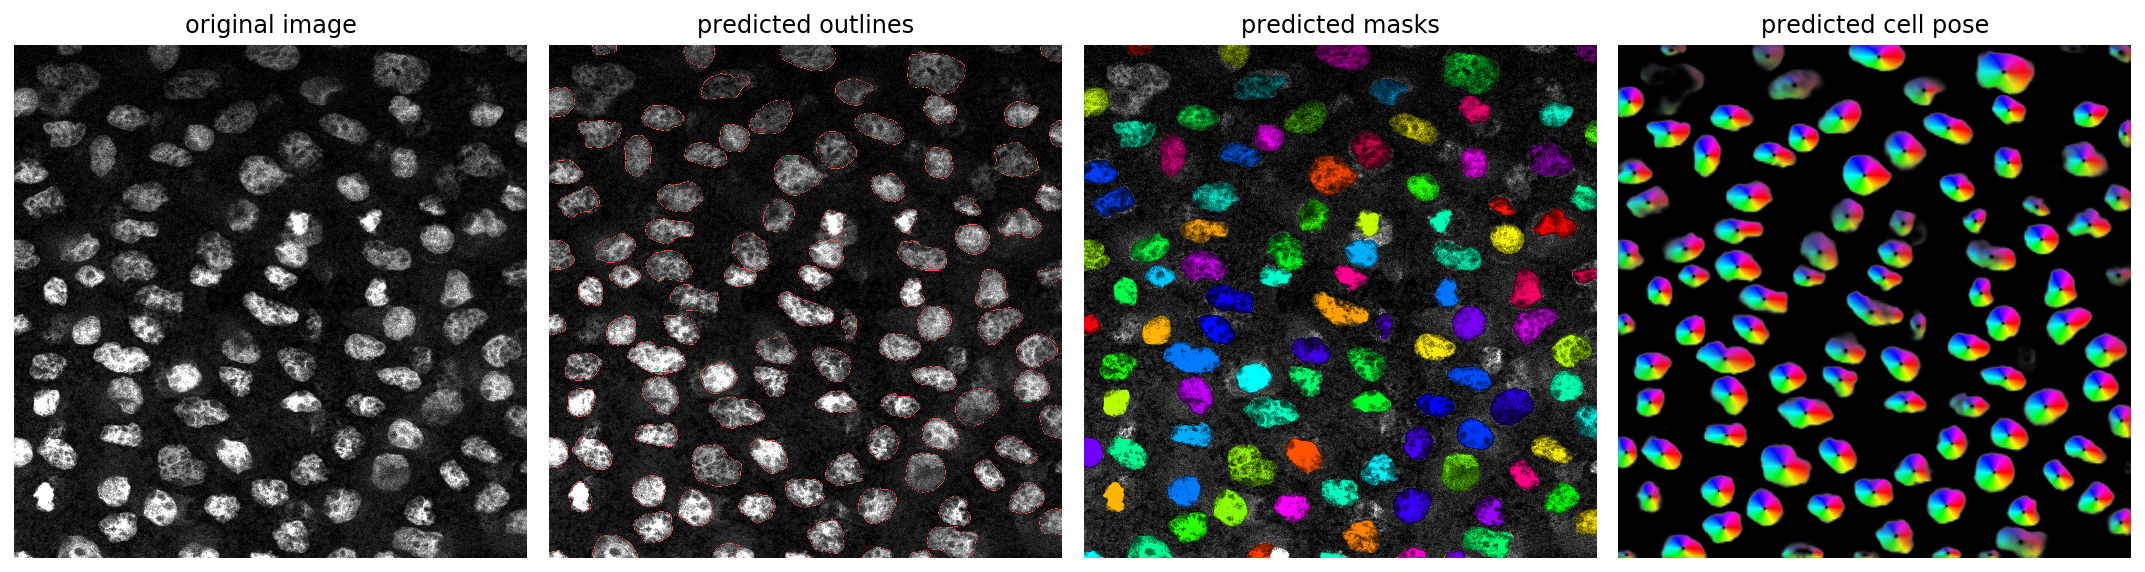

In [22]:
from cellpose import plot

fig = plt.figure(figsize=(15,15))
plot.show_segmentation(fig, X_val[0], masks[0], flows[0][0], channels=[0,0])
plt.tight_layout()
plt.show()

In [38]:
masks2, flows2, styles2 = cpnet2.eval(X_val, channels=[0,0], invert=False, rescale=0.25, do_3D=False, net_avg=False, 
                                  tile=False, flow_threshold=0.4, cellprob_threshold=0.0, compute_masks=True, progress=None)

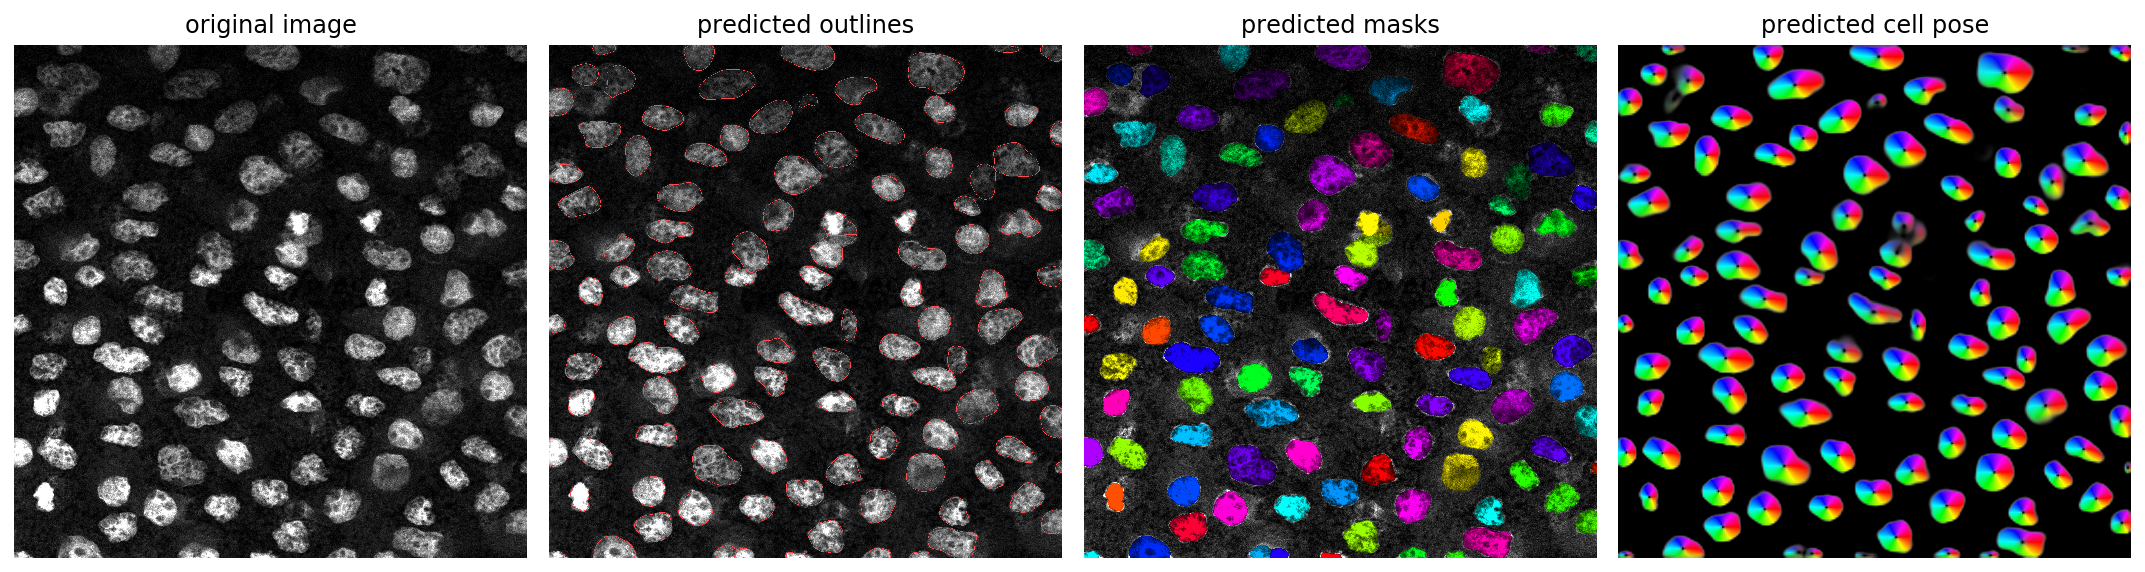

In [39]:
fig = plt.figure(figsize=(15,15))
plot.show_segmentation(fig, X_val[0], masks2[0], flows2[0][0], channels=[0,0])
plt.tight_layout()
plt.show()

## Train with GDT method to generate target (Y)

In [12]:
model0.cp.net.downsample.down[0].conv[0][2].weight.data()[0]


[[[ 0.04114713  0.0824549   0.5053643 ]
  [-0.10932951 -0.87627375 -0.20008686]
  [ 0.20691864 -0.23023081  0.08594982]]

 [[-0.01360054  0.00572765 -0.00556034]
  [ 0.02173528  0.0197194   0.00890682]
  [-0.00245167 -0.0068812   0.00553805]]]
<NDArray 2x3x3 @gpu(0)>

In [43]:
# model0.cp.net.load_parameters(path)

In [13]:
model0.cp.train(X_trn, Y_trn, test_data=X_val, test_labels=Y_val, channels=[0,0], train_flows=flow_trn2, test_flows=flow_val2,
              pretrained_model=None, save_path='../', save_every=100, 
              learning_rate=0.2, n_epochs=500, weight_decay=0.00001, batch_size=4, rescale=True)

>>>> training network with 2 channel input <<<<
>>>> saving every 100 epochs
>>>> median diameter = 15
>>>> LR: 0.20000, batch_size: 4, weight_decay: 0.00001
>>>> ntrain = 4
>>>> ntest = 1
(2, 1022, 1022)
Epoch 0, Time  2.9s, Loss 0.6636, Loss Test 0.4201, LR 0.0000
Epoch 1, Time  3.1s, Loss 0.6236, Loss Test 0.4198, LR 0.0222
saving network parameters to: ../models/cellpose_False__2020_05_25_19_28_26.363082
Epoch 2, Time  3.3s, Loss 0.6915, Loss Test 0.4170, LR 0.0444
Epoch 3, Time  3.5s, Loss 0.6780, Loss Test 0.4110, LR 0.0667
Epoch 4, Time  3.6s, Loss 0.6265, Loss Test 0.4067, LR 0.0889
Epoch 5, Time  3.8s, Loss 0.5567, Loss Test 0.4085, LR 0.1111
Epoch 6, Time  3.9s, Loss 0.5088, Loss Test 0.4111, LR 0.1333
Epoch 7, Time  4.0s, Loss 0.4431, Loss Test 0.4053, LR 0.1556
Epoch 8, Time  4.2s, Loss 0.4876, Loss Test 0.3934, LR 0.1778
Epoch 9, Time  4.3s, Loss 0.4839, Loss Test 0.3774, LR 0.2000
Epoch 10, Time  4.5s, Loss 0.4469, Loss Test 0.3678, LR 0.2000
Epoch 20, Time  5.8s, Loss 0.

In [14]:
model0.cp.net.downsample.down[0].conv[0][2].weight.data()[0]


[[[-0.04385046 -0.00449207  0.39640224]
  [-0.16190995 -0.90895325 -0.2766785 ]
  [ 0.13492422 -0.27372545  0.01278769]]

 [[-0.01349027  0.00568122 -0.00551528]
  [ 0.02155902  0.01955957  0.0088346 ]
  [-0.0024318  -0.00682541  0.00549316]]]
<NDArray 2x3x3 @gpu(0)>

In [15]:
## nuclei diam = 60, rescale = 15/60 = 0.25
masks, flows, styles = model0.cp.eval(X_val, channels=[0,0], invert=False, rescale=0.25, do_3D=False, net_avg=False, 
                                  tile=True, flow_threshold=0.4, cellprob_threshold=0.0, compute_masks=True, progress=None)

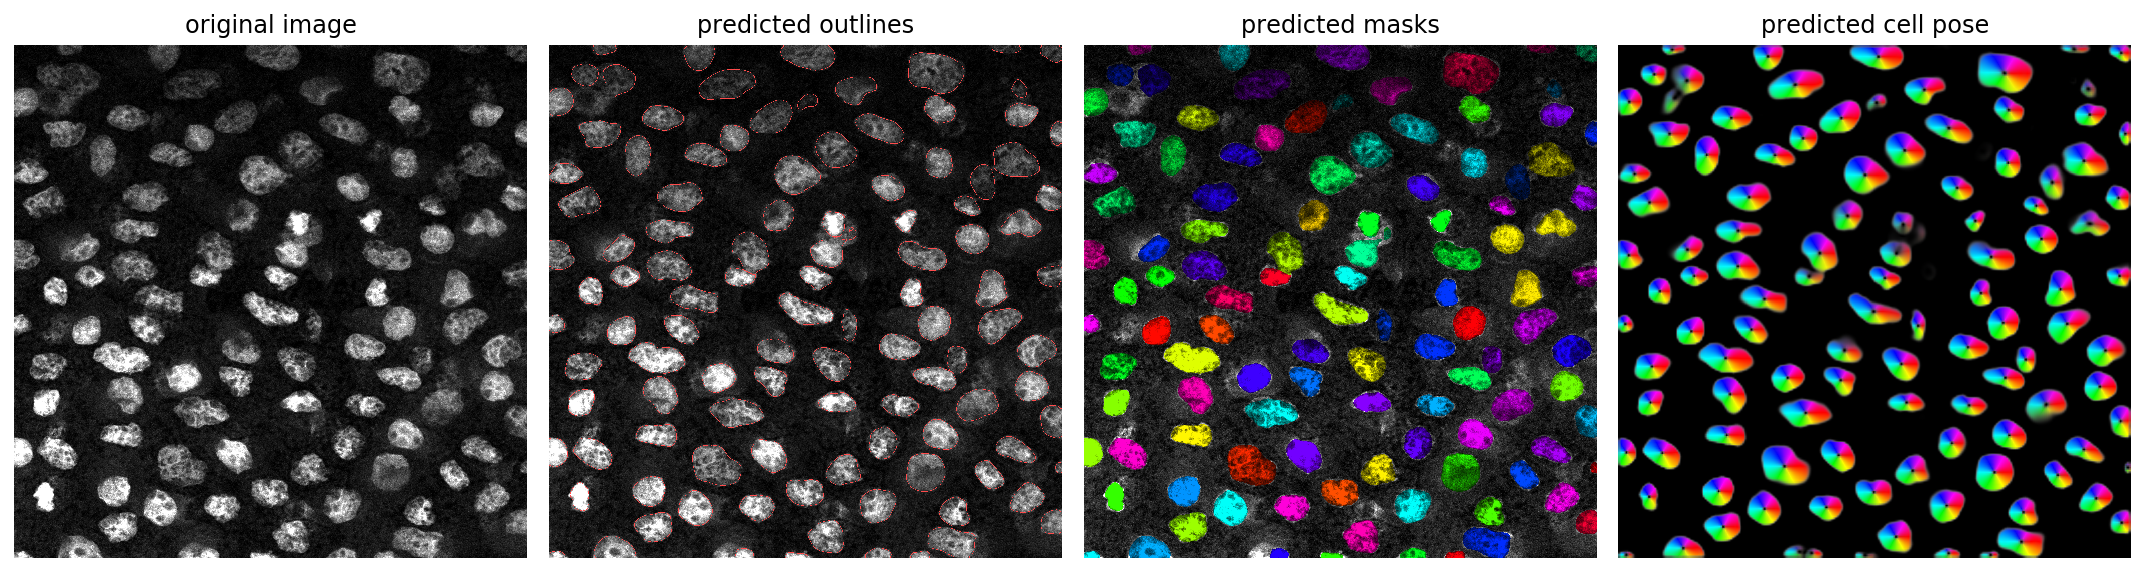

In [18]:
fig = plt.figure(figsize=(15,15))
plot.show_segmentation(fig, X_val[0], masks[0], flows[0][0], channels=[0,0])
plt.tight_layout()
plt.show()